In [1]:
import time

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Transformations for the training dataset
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(0.02),  # Randomly rotate images by a small angle
    transforms.RandomResizedCrop(224),  # Randomly crop and resize images to 224x224
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

# Transformations for the validation dataset
val_transforms = transforms.Compose([
    transforms.Resize(224),  # Resize images to 224x224
    transforms.CenterCrop(224),  # Center crop images to 224x224
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

# Loading datasets
train_dataset = datasets.ImageFolder('./chest_xray/train', transform=train_transforms)  # Training dataset
val_dataset = datasets.ImageFolder('./chest_xray/val', transform=val_transforms)  # Validation dataset
test_dataset = datasets.ImageFolder('./chest_xray/test', transform=val_transforms)  # Test dataset

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Training data loader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # Validation data loader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Test data loader


In [3]:
classes = train_dataset.classes
n_classes = len(classes)
print("Total classes:", n_classes)
print("Classes:", classes)

from collections import Counter
train_counts = Counter([train_dataset.targets[i] for i in range(len(train_dataset))])
print("Distribution of classes in the training set:", train_counts)

Total classes: 2
Classes: ['NORMAL', 'PNEUMONIA']
Distribution of classes in the training set: Counter({1: 3875, 0: 1341})


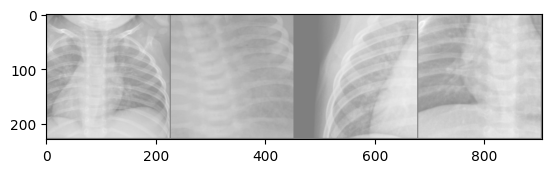

NORMAL PNEUMONIA PNEUMONIA NORMAL


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# show labels
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))

In [5]:
def get_image_size(loader):
    for images, _ in loader:
        # Return the height and width of the images
        return images.size()

# Get the image size in the training dataset
train_image_size = get_image_size(train_loader)
print("Image size in the training set:", train_image_size)

Image size in the training set: torch.Size([32, 3, 224, 224])


In [6]:
def calculate_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    
    # Iterate through the data loader
    for images, _ in loader:
        batch_samples = images.size(0)
        
        # Reshape the images for computation
        images = images.view(batch_samples, images.size(1), -1)
        
        # Calculate mean and standard deviation
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples
    
    # Calculate the overall mean and standard deviation
    mean /= total_images_count
    std /= total_images_count
    
    return mean, std

# Calculate mean and standard deviation for the training data
train_mean, train_std = calculate_mean_std(train_loader)
print("Training Set Mean:", train_mean)
print("Training Set Standard Deviation:", train_std)

Training Set Mean: tensor([0.5533, 0.5533, 0.5533])
Training Set Standard Deviation: tensor([0.1583, 0.1583, 0.1583])


In [7]:
def get_same_padding(kernel_size):
    pad = kernel_size // 2
    return pad

In [8]:
import torchvision.models as models

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Use ResNet18 as base
        resnet = models.resnet18(pretrained=True)
        self.base = nn.Sequential(*list(resnet.children())[:-2])  # Remove the last 2 layers

        # Last Conv layer
        self.conv4 = nn.Conv2d(512, 128, kernel_size=3, stride=1, padding=1)  # Adjunst the number of chanels from the ResNet-18's last layer
        self.bn4 = nn.BatchNorm2d(128)

        # We get the exact size of the last layer
        self.flat_features = self._get_conv_output((1, 3, 224, 224))

        # Capa Fully Connected y Dropout
        self.fc1 = nn.Linear(self.flat_features, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 1)

    def _get_conv_output(self, shape):
        with torch.no_grad():
            input = torch.rand(*shape)
            output = self._forward_features(input)
            return int(np.prod(output.size()))

    def _forward_features(self, x):
        x = self.base(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.adaptive_avg_pool2d(x, (1, 1))
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(-1, self.flat_features)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

model = CustomCNN()

/home/matcraft/anaconda3/envs/math/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/matcraft/anaconda3/envs/math/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
from torchsummary import summary
summary(model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 64, 56, 56]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 56, 56]          73,984
|    └─Sequential: 2-6                   [-1, 128, 28, 28]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 28, 28]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 28, 28]         295,424
|    └─Sequential: 2-7                   [-1, 256, 14, 14]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 14, 14]     

/home/matcraft/anaconda3/envs/math/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 64, 56, 56]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 56, 56]          73,984
|    └─Sequential: 2-6                   [-1, 128, 28, 28]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 28, 28]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 28, 28]         295,424
|    └─Sequential: 2-7                   [-1, 256, 14, 14]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 14, 14]     

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()# nn.BCEWithLogitsLoss()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
model = model.to(device)

In [13]:
# Params
num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# Training
for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Cealn Gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        outputs = outputs.squeeze()

        # Convert labels to floats
        labels = labels.float()
        outputs = outputs.float()

        # Calculeta loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Add training loss
        train_loss += loss.item() * inputs.size(0)

        # Calculate the training accuracy
        predicted_train = outputs > 0.7  # Threshold
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    # Calculate the mean loss and mean accuracy from training
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            outputs = outputs.squeeze()

            # Convert the labels and outputs to floats
            labels = labels.float()
            outputs = outputs.float()

            # calculate loss
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            predicted = outputs > 0.7  # Threshold
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate the mean loss and mean accuracyfrom validation
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    epoch_duration = time.time() - start_time

    print(f'Epoch {epoch+1}/{num_epochs} - '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}% - '
          f'Time: {epoch_duration:.2f}s')

Epoch 1/10 - Train Loss: 0.3131, Train Accuracy: 83.26% - Validation Loss: 0.3563, Validation Accuracy: 75.00% - Time: 85.71s
Epoch 2/10 - Train Loss: 0.2640, Train Accuracy: 87.12% - Validation Loss: 0.5889, Validation Accuracy: 75.00% - Time: 85.63s
Epoch 3/10 - Train Loss: 0.2400, Train Accuracy: 88.78% - Validation Loss: 0.7884, Validation Accuracy: 56.25% - Time: 86.20s
Epoch 4/10 - Train Loss: 0.2183, Train Accuracy: 90.47% - Validation Loss: 1.9237, Validation Accuracy: 62.50% - Time: 85.92s
Epoch 5/10 - Train Loss: 0.2135, Train Accuracy: 90.34% - Validation Loss: 1.0468, Validation Accuracy: 68.75% - Time: 85.84s
Epoch 6/10 - Train Loss: 0.2127, Train Accuracy: 90.72% - Validation Loss: 0.5726, Validation Accuracy: 81.25% - Time: 85.91s
Epoch 7/10 - Train Loss: 0.1831, Train Accuracy: 91.97% - Validation Loss: 0.9554, Validation Accuracy: 62.50% - Time: 85.89s
Epoch 8/10 - Train Loss: 0.1851, Train Accuracy: 91.70% - Validation Loss: 0.8273, Validation Accuracy: 75.00% - Time:

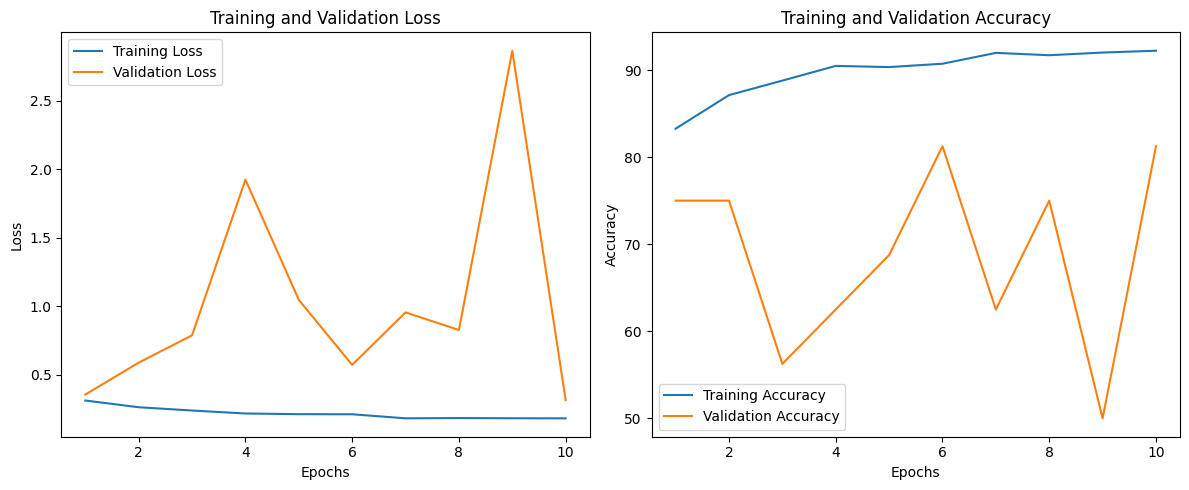

In [14]:
import matplotlib.pyplot as plt

# Training and validation loss and accuracy
epochs = range(1, num_epochs + 1)

# Plotting training and validation losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
prediction_probabilities = []

# Put the model in evaluation mode
model.eval()

# Lists to store true labels and predictions
true_labels = []
predictions = []

# Disable gradient calculations
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move data to the device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Make predictions
        outputs = model(inputs)
        outputs = outputs.squeeze()  # Remove any extra dimensions

        # Convert outputs to predicted labels
        predicted_labels = (outputs > 0.7).float()  # Adjust threshold if necessary

        # Save the true labels and predictions
        true_labels.extend(labels.cpu().numpy())  # Move labels back to CPU and convert to NumPy array
        predictions.extend(predicted_labels.cpu().numpy())  # Move predictions back to CPU and convert to NumPy array
        prediction_probabilities.extend(outputs.cpu().numpy())

# Convert lists to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)
prediction_probabilities = np.array(prediction_probabilities)

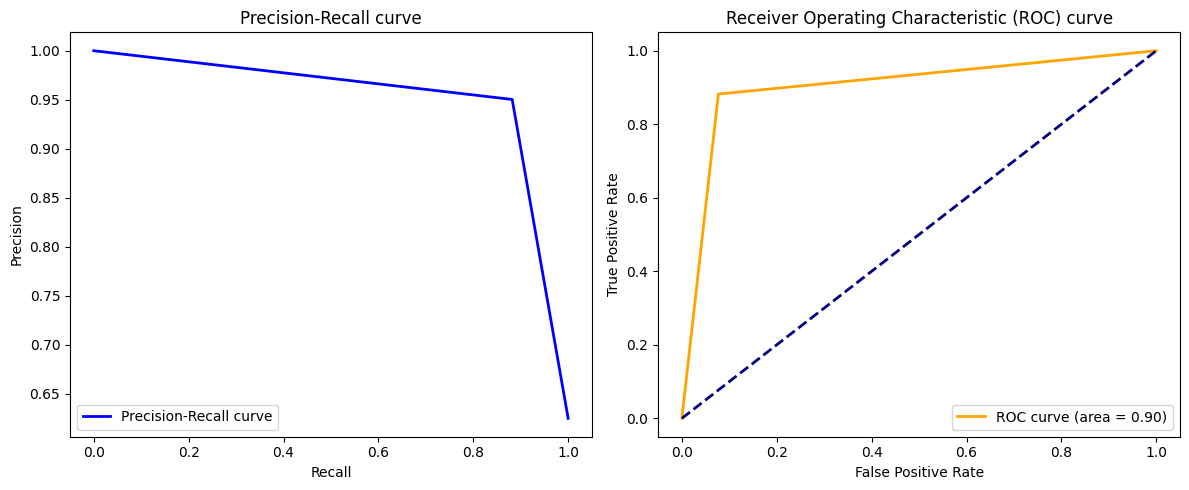

In [16]:
import numpy as np

# Precision-Recall curve and ROC curve
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Calculating Precision-Recall values
precision, recall, _ = precision_recall_curve(true_labels, predictions)

# Calculating ROC values
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plotting Precision-Recall curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")

# Plotting ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()



Precision-Recall Curve: This graph shows a relatively high precision across most levels of recall until it drops sharply towards the end. This indicates that for most thresholds, your model can maintain high precision (low false positive rate), but there may be a threshold where the precision falls off, suggesting a trade-off that needs to be carefully chosen based on your application's requirement for precision versus recall.

Receiver Operating Characteristic (ROC) Curve: The ROC curve is close to the left-hand border and then bends towards the top border, which suggests a good performance of the model in distinguishing between the classes. The area under the ROC curve (AUC) is 0.90, which is quite high, indicating that the model has a good measure of separability and is able to distinguish between positive and negative classes well.

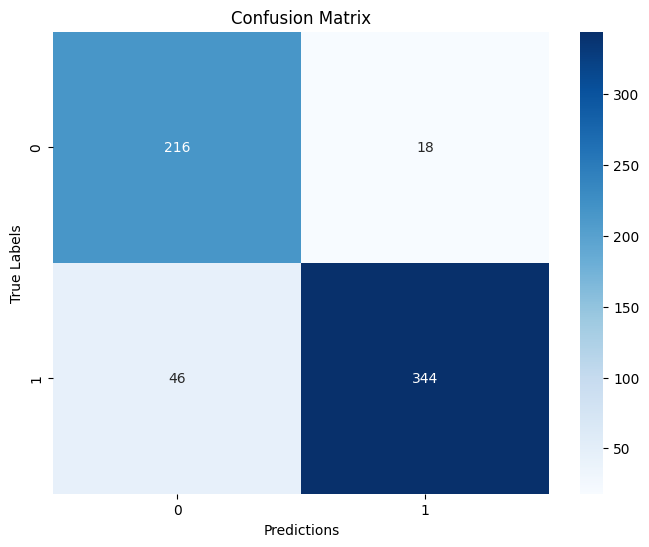

In [17]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Visualization of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')  # Annotate each cell with the numeric value
plt.xlabel('Predictions')  # Label for the x-axis
plt.ylabel('True Labels')  # Label for the y-axis
plt.title('Confusion Matrix')  # Title of the plot
plt.show()

In [18]:
from sklearn.metrics import classification_report

# Generar un reporte de clasificación
report = classification_report(true_labels, predictions, target_names=['Class 0', 'Class 1'])
print(report)

              precision    recall  f1-score   support

     Class 0       0.82      0.92      0.87       234
     Class 1       0.95      0.88      0.91       390

    accuracy                           0.90       624
   macro avg       0.89      0.90      0.89       624
weighted avg       0.90      0.90      0.90       624



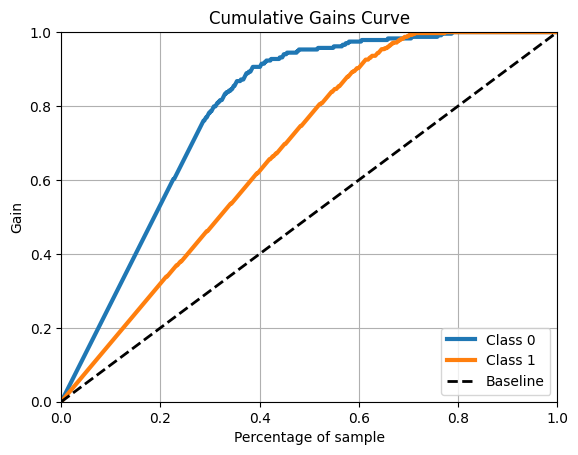

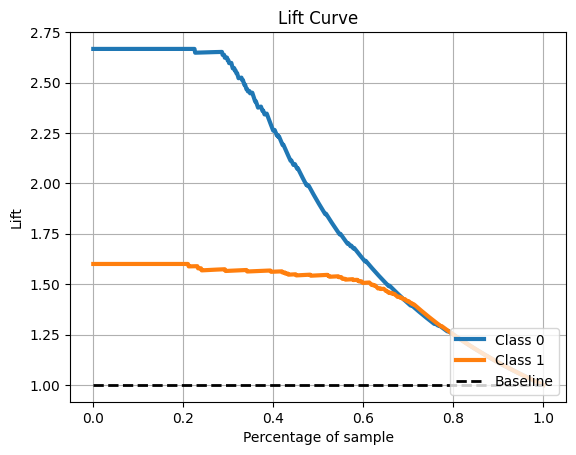

In [19]:
prediction_probabilities_2d = np.vstack((1 - prediction_probabilities, prediction_probabilities)).T

import scikitplot as skplt

# Curva de Ganancia Acumulativa
skplt.metrics.plot_cumulative_gain(true_labels, prediction_probabilities_2d)
plt.show()

# Curva Lift
skplt.metrics.plot_lift_curve(true_labels, prediction_probabilities_2d)
plt.show()

## Model Performance Analysis

### Cumulative Gains Curve
The Cumulative Gains Curve provides insight into the effectiveness of the model in identifying positive instances as compared to a random guess. The curve for Class 1, shown in orange, should ideally be far from the baseline (dashed line) and close to the top-left corner for the model to be considered effective. From the graph, we observe that the model significantly outperforms the baseline, especially in the top deciles of the data, which suggests that the model is efficient in distinguishing between the positive and the negative classes early on.

### Lift Curve
The Lift Curve complements the analysis by showing the improvement in prediction of the positive class (Class 1) over random guessing. A lift value greater than 1 indicates that the model is doing better than a random selection. The initial high lift for Class 1 (orange curve) indicates that the model performs well in identifying the positive cases from the outset. The model's ability to correctly identify positive cases decreases as more of the sample is considered, which is a typical pattern for lift curves.

### Interpretation

The analysis of both the Cumulative Gains and Lift Curves suggests that the model has a strong ability to identify positive instances. This is particularly useful in scenarios where interventions are limited to a subset of the entire sample, such as targeting marketing campaigns to users most likely to convert. The significant initial lift indicates that the model could be a valuable tool in prioritizing instances for these targeted interventions.

It's important to keep in mind that these curves are most beneficial when there's a need to prioritize a specific class and when the cost of intervention is high. In such cases, the model can be used to ensure that resources are allocated where they have the highest likelihood of achieving the desired outcome.


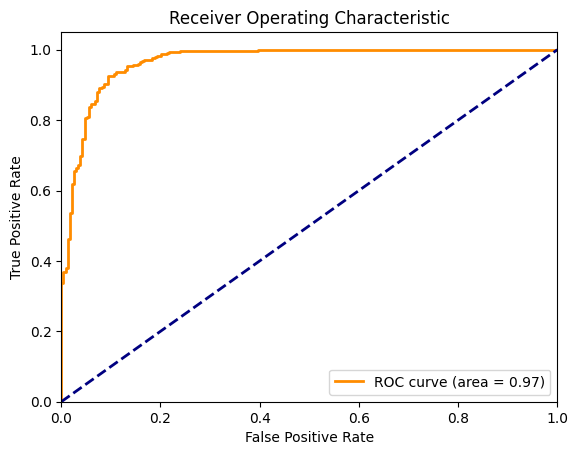

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(true_labels, prediction_probabilities)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


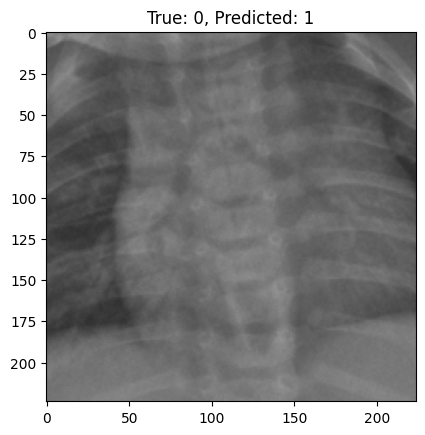

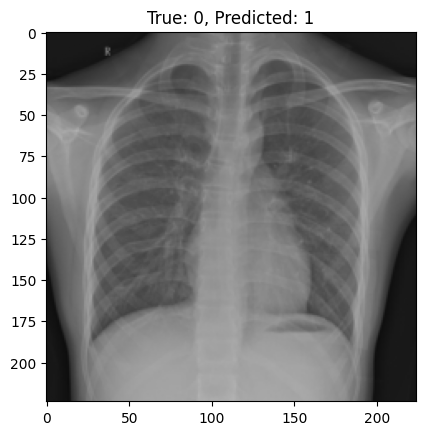

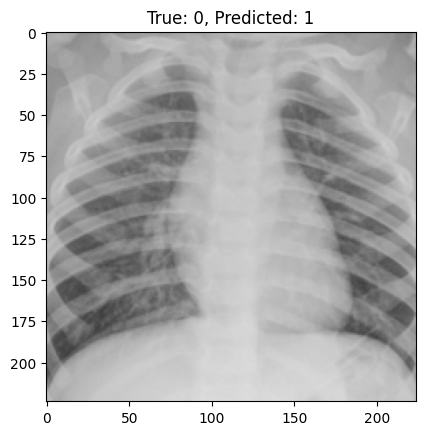

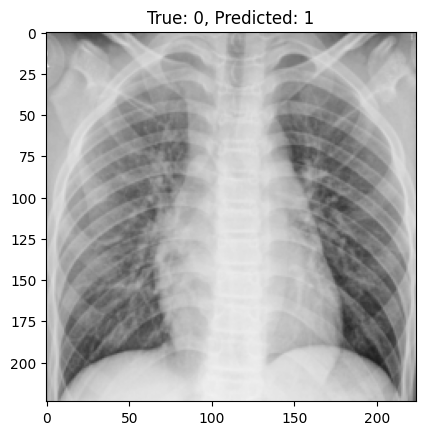

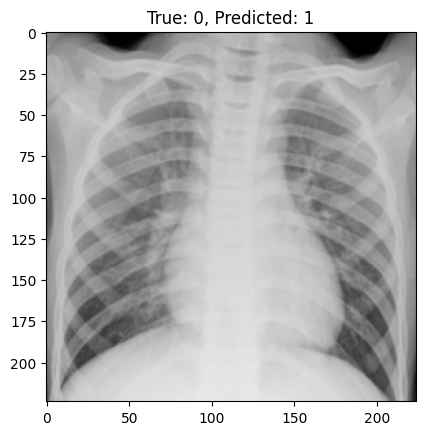

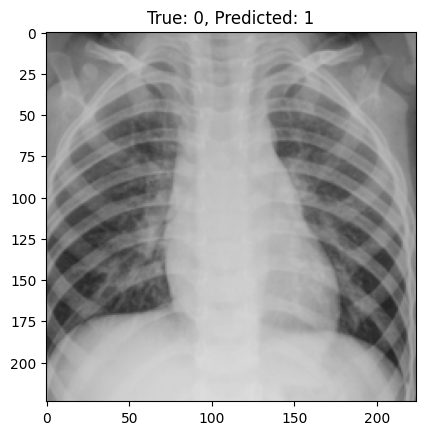

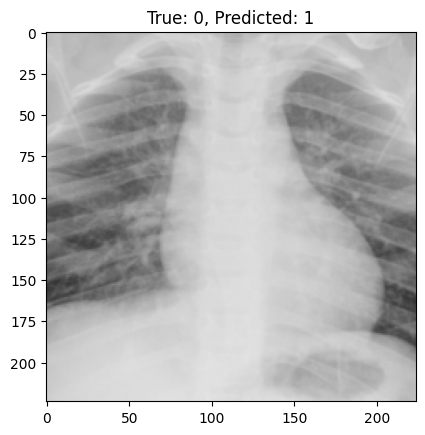

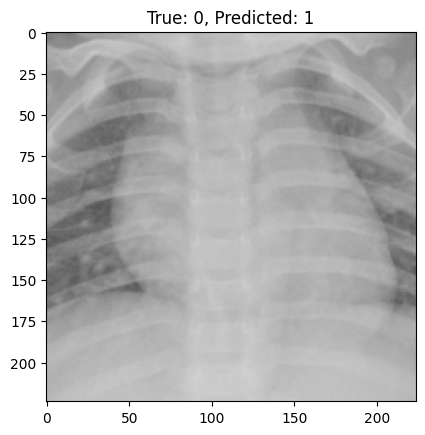

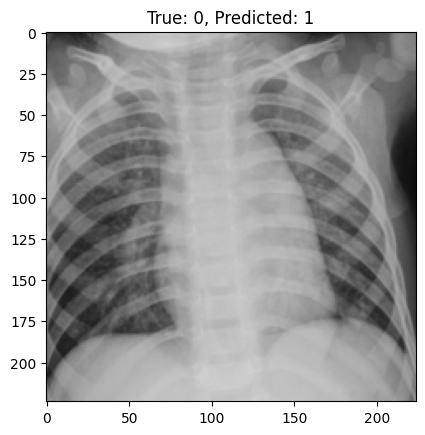

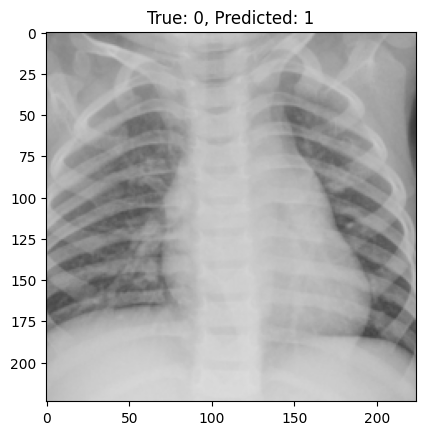

In [21]:
# Assuming you have a list of images, true labels, and predictions
wrong_predictions = [i for i, (true, pred) in enumerate(zip(true_labels, predictions)) if true != pred]
test_images = [inputs for inputs, labels in test_loader]

# Calculate batch size
batch_size = test_images[0].size(0)

# To visualize misclassified images
for idx in wrong_predictions[:10]:  # Show the first 10 misclassified images
    batch_index = idx // batch_size  # Batch index
    image_index = idx % batch_size  # Image index within the batch

    image = test_images[batch_index][image_index]  # Get the specific image
    image = image.permute(1, 2, 0)  # Change the channel order for matplotlib (h, w, c)
    plt.imshow(image.numpy(), cmap='gray')  # Convert to numpy and show the image
    plt.title(f"True: {int(true_labels[idx])}, Predicted: {int(predictions[idx])}")
    plt.show()

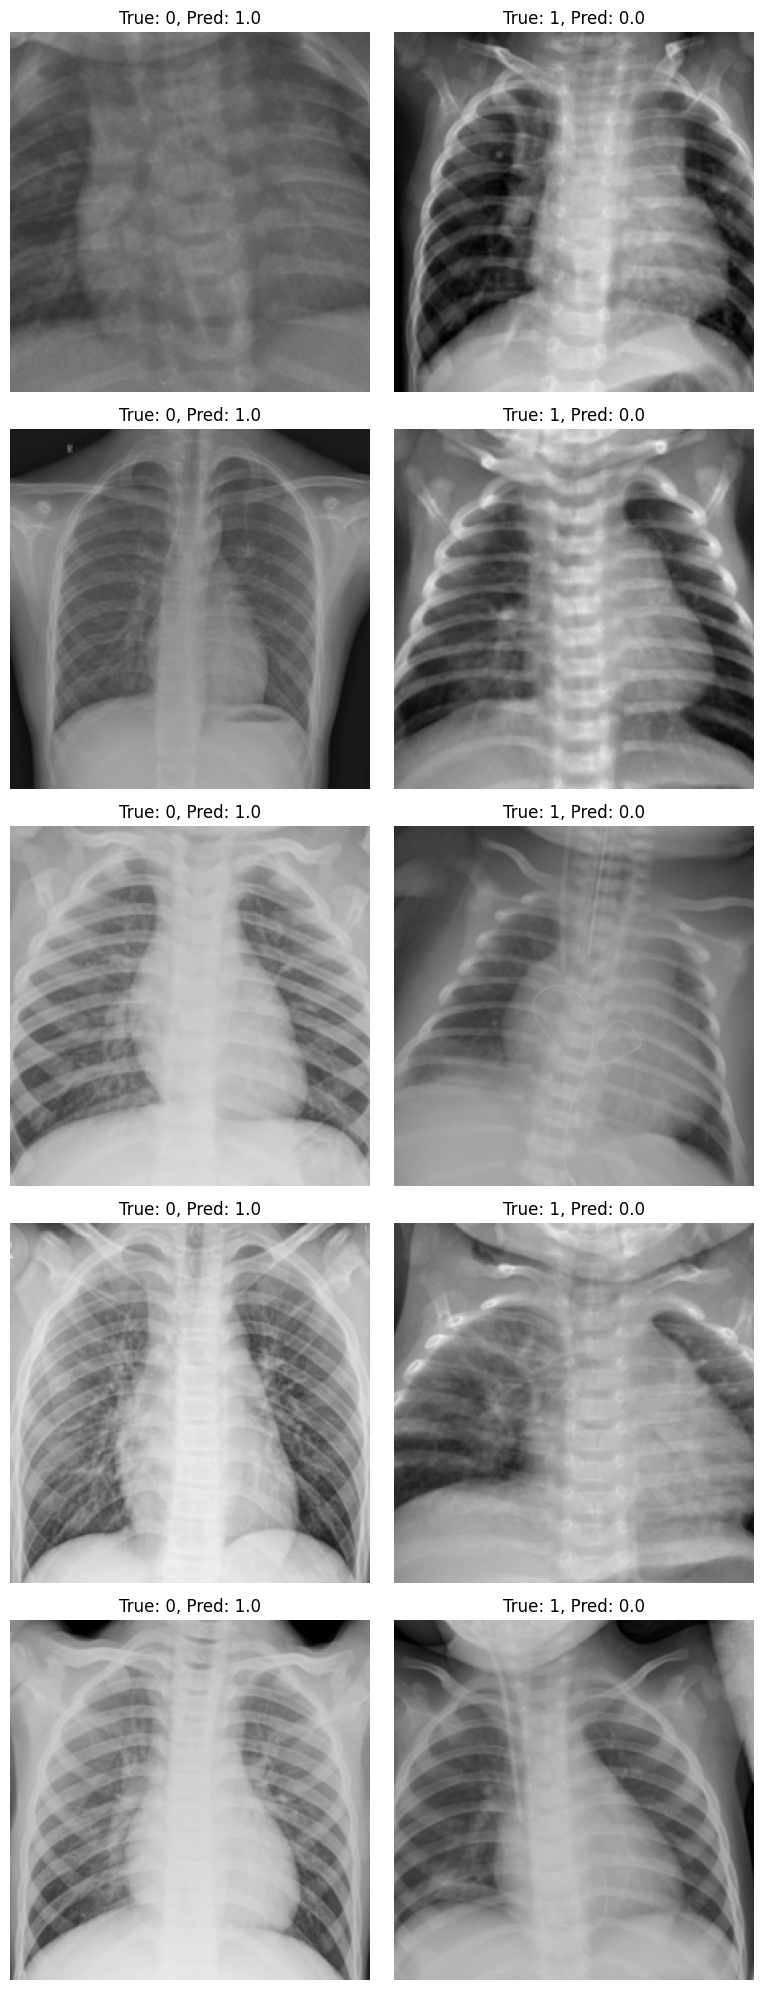

In [22]:
# Suponiendo que tienes una lista de imágenes, etiquetas verdaderas y predicciones
wrong_predictions = [(i, true, pred) for i, (true, pred) in enumerate(zip(true_labels, predictions)) if true != pred]
test_images = [inputs for inputs, labels in test_loader]

# Organizar las imágenes mal clasificadas por etiqueta verdadera
wrong_by_label = {}
for idx, true, pred in wrong_predictions:
    if true not in wrong_by_label:
        wrong_by_label[true] = []
    wrong_by_label[true].append((idx, pred))

# Calcular el tamaño del lote
batch_size = test_images[0].size(0)

# Número máximo de imágenes por etiqueta
max_images_per_label = 5

# Crear una figura para visualizar las imágenes
num_labels = len(wrong_by_label)
fig, axs = plt.subplots(nrows=max_images_per_label, ncols=num_labels, figsize=(num_labels*4, max_images_per_label*4))

# Llenar la figura con las imágenes mal clasificadas
for col, (label, images) in enumerate(wrong_by_label.items()):
    for row, (idx, pred) in enumerate(images[:max_images_per_label]):
        batch_index = idx // batch_size
        image_index = idx % batch_size
        image = test_images[batch_index][image_index].permute(1, 2, 0)
        
        axs[row, col].imshow(image.numpy(), cmap='gray')
        axs[row, col].set_title(f"True: {label}, Pred: {pred}")
        axs[row, col].axis('off')

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()